# Assignment 3.1 Finding Circles with RANSAC
---
Group 3:
* Jiye Lee
* Eduardo Venegas Hernández
---

Import Libraries

In [200]:
import Pkg

using Images
using FileIO
using Plots

1. Preprocessing. Find potential edge points of the circle. You may choose whatever
method you find appropriate, for example Laplacian zero-crossings or a Canny detector

In [201]:
# load Images
img1 = Gray.(load("images/image1.png"));
img3 = Gray.(load("images/image3.png"));
img4 = Gray.(load("images/image4.png"));
img5 = Gray.(load("images/image5.png"));

In [202]:
function edge_detection(img::AbstractArray{T, 2}) where T <: AbstractGray
    kernel = [0 1 0; 1 -4 1; 0 1 0]
    convolved = imfilter(img, kernel)
    return 20*convolved
end

edge_detection (generic function with 1 method)

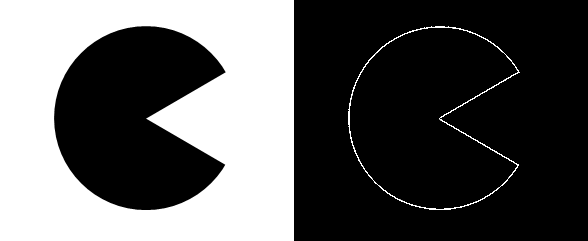

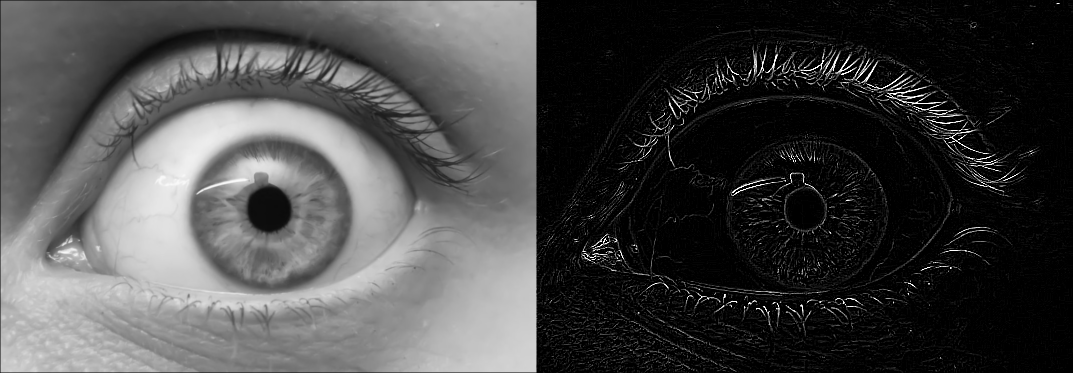

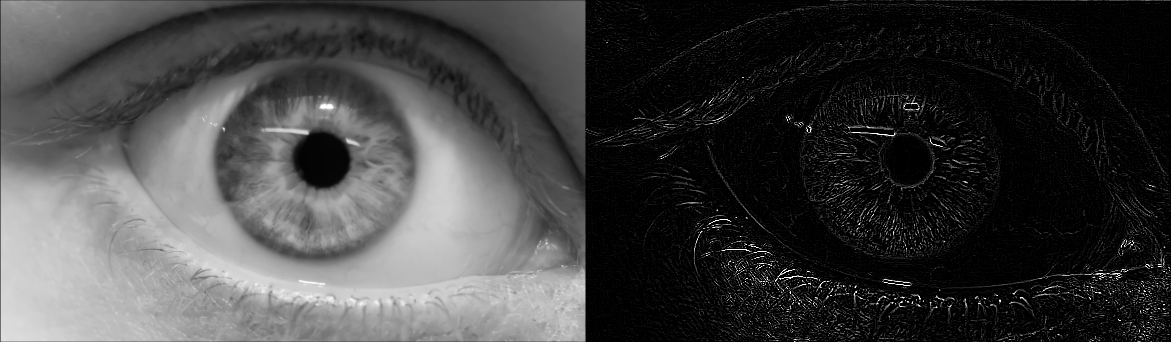

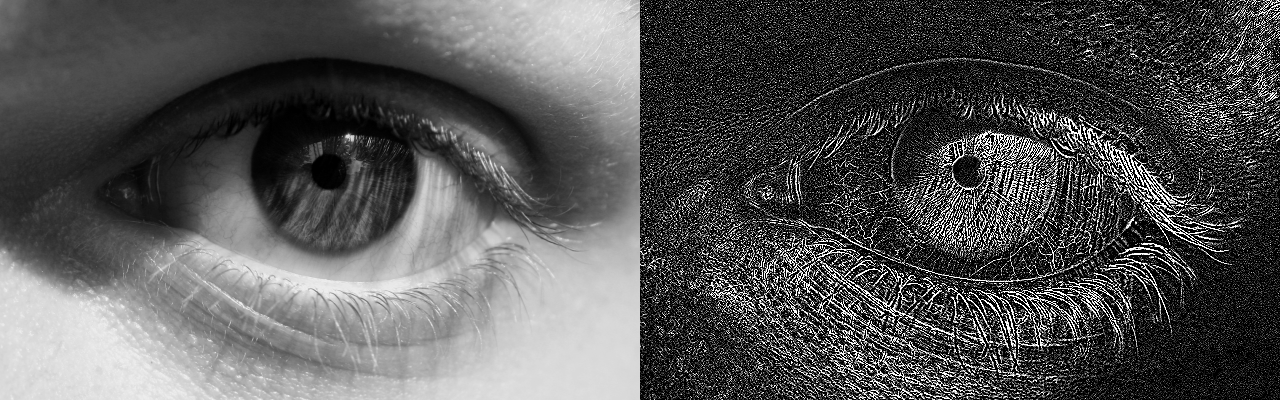

In [203]:
# conduct edge_detection on all images and display them
img1_edges = edge_detection(img1)
img3_edges = edge_detection(img3)
img4_edges = edge_detection(img4)
img5_edges = edge_detection(img5)


display(mosaicview(img1, img1_edges, nrow=1))
display(mosaicview(img3, img3_edges, nrow=1))
display(mosaicview(img4, img4_edges, nrow=1))
display(mosaicview(img5, img5_edges, nrow=1))

2. Circle parameters. Write a function outercircle(p1, p2, p3) which takes three input points pi = (xi; yi) with i = 1, 2, 3. The function should calculate center location (a, b) and radius r =√(c + a^2 + b^2) of a circle that passes through all three input points.

In [204]:
# Write a function outercircle(p1, p2, p3) which takes three input points pi = (xi; yi) with i = 1, 2, 3. 
#The function should calculate center location (a, b) and radius r of a circle that passes through all three input points. 

function outercircle(p1, p2, p3)
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    a = (x1^2 + y1^2)*(y2 - y3) + (x2^2 + y2^2)*(y3 - y1) + (x3^2 + y3^2)*(y1 - y2)
    a /= 2*(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    b = (x1^2 + y1^2)*(x3 - x2) + (x2^2 + y2^2)*(x1 - x3) + (x3^2 + y3^2)*(x2 - x1)
    b /= 2*(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    r = sqrt((x1 - a)^2 + (y1 - b)^2)
    return a, b, r
end

outercircle (generic function with 1 method)

3. Target function. The function modelquality() is supposed to determine how many edge points support (i.e., are close to) the circle given by a parameter triple a, b, r. A
suitable distance criterion has to be used, within which an edge point is still considered to lie on the circle (e.g., distance from the circle line). The function should return
a quality estimate q.

In [233]:
# Target function. The function modelquality() is supposed to determine how many edge points support (i.e., are close to) the circle given by a parameter triple a, b, r.
# A suitable distance criterion has to be used, within which an edge point is still considered to lie on the circle (e.g., distance from the circle line). 
#The function should return a quality estimate q. 
#Hint: Monitoring the quality q is useful to check whether the following steps work correctly. In general, the best quality found should increase with a higher number of iterations.

function modelquality(a, b, r, edgepoints)
    q = 0
    for p in edgepoints
        x, y = p

        if r-0.1<=sqrt((x - a)^2 + (y - b)^2)<=r+0.1
            q += 1
        end
    end
    return q
end

modelquality (generic function with 1 method)

4. Necessary repetitions. Implement the function getK(pmax, aout, M) which calculates
the number of repetitions required to ensure that for a given outlier frequency aout the
probability of drawing only invalid sample sets M remains below a given probability
threshold pmax. Use e.g., aout = 0.8, pmax = 0.01.

In [206]:
#Implement the function getK

function getK(pmax, aout, M)
    return ceil(Int, log(pmax)/log(1 - (1 - aout)^M))
end

getK (generic function with 1 method)

In [207]:
getK(0.01, 0.8, 3)

574

5. RANSAC. Implement the RANSAC algorithm according to the lecture notes. The function fit_circle_ransac(image) should return the best fitting parameters a, b, and r, as well as the quality q for these parameters

In [243]:
#RANSAC. 
#Implement the RANSAC algorithm according to the lecture notes. 
#The function fit_circle_ransac(image) should return the best fitting parameters a, b, and r, as well as the quality q for these parameters

function fit_circle_ransac(image)
    edgepoints = []
    for i in 1:size(image)[1]
        for j in 1:size(image)[2]
            if image[i, j] > 0.5
                push!(edgepoints, (i, j))
            end
        end
    end
    pmax = 0.01
    aout = 0.8
    M = 3
    K = getK(pmax, aout, M)
    bestq, besta, bestb, bestr = 0, 0, 0, 0
    a, b, r = 0, 0, 0
    for k in 1:K

        while true
            p1 = edgepoints[rand(1:length(edgepoints))]
            p2 = edgepoints[rand(1:length(edgepoints))]
            p3 = edgepoints[rand(1:length(edgepoints))]
            a, b, r = outercircle(p1, p2, p3)
            if a+r < size(image)[2] && b+r < size(image)[1] && a-r > 1 && b-r > 1
                break
            end
        end
        q = modelquality(a, b, r, edgepoints)
        if q > bestq
            bestq = q
            besta = a
            bestb = b
            bestr = r
        end
    end
    print("bestq: ", bestq, " besta: ", besta, " bestb: ", bestb, " bestr: ", bestr)
    return besta, bestb, bestr, bestq
end

fit_circle_ransac (generic function with 1 method)

In [209]:
fit_circle_ransac(img5_edges)

bestq: 475 besta: 258.64035565851333 bestb: 251.06789534646046 bestr: 137.93818484553103

(258.64035565851333, 251.06789534646046, 137.93818484553103, 475)

6. Tests. Apply your implementation of the RANSAC algorithm to images image[1-4].png after converting them to greyscale. Visualize the best found circle on top of the image.


In [210]:
function draw_circle( a, b, r)
    theta = range(0, 2π, length=100)
    a.+(r.*cos.(theta)), b.+(r.*sin.(theta))
end

draw_circle (generic function with 1 method)

In [227]:
function test_ransac(img::AbstractArray{T, 2}) where T <: AbstractGray
    a, b, r, q = fit_circle_ransac(img)
    plot(img)
    # plot b, a because of difference between the way images are stored and plotted
    plot!(draw_circle(b, a, r), seriestype=[:shape,], lw=0.5, linecolor=:blue, fillalpha=0)
end

test_ransac (generic function with 1 method)

bestq: 112 besta: 119.08591491119373 bestb: 146.60470879801736 bestr: 91.05914070617499

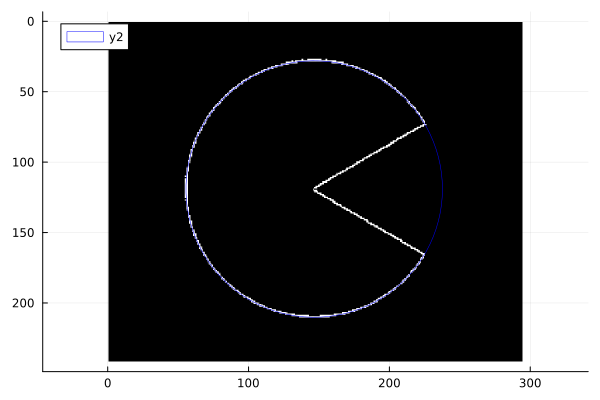

In [244]:
test_ransac(img1_edges)

bestq: 47 besta: 347.4130434782609 bestb: 463.2391304347826 bestr: 236.6348534667628

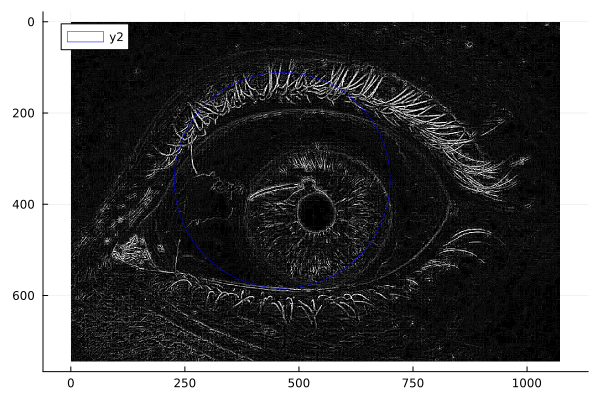

In [245]:
test_ransac(img3_edges)

bestq: 33 besta: 370.7158186397985 bestb: 387.6425692695214 bestr: 181.38625486182872

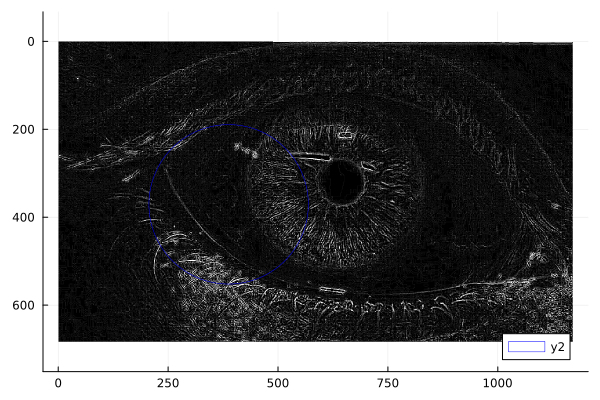

In [246]:
test_ransac(img4_edges)

bestq: 61 besta: 212.04125998225376 bestb: 218.99482401656314 bestr: 154.2797443887063

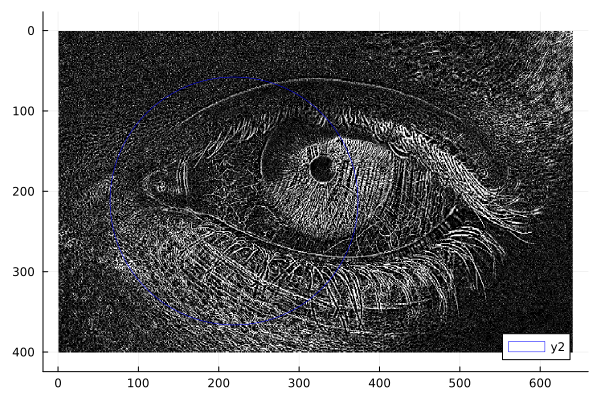

In [247]:
test_ransac(img5_edges)

bestq: 146 besta: 265.16844715757344 bestb: 327.95359595574206 bestr: 155.01049399352277

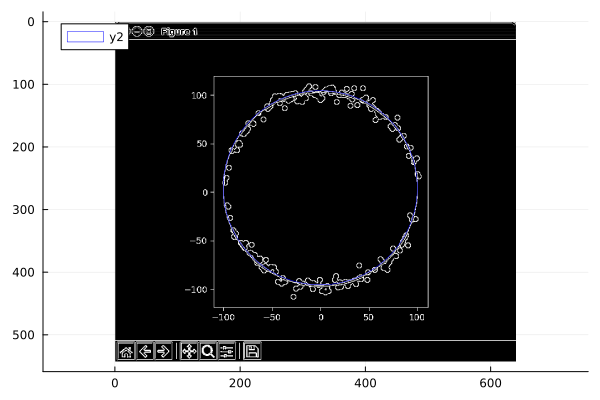

In [249]:
img_test=Gray.(load("images/Test.png"))
img_test_edges=edge_detection(img_test)
test_ransac(img_test_edges)
